In [1]:
import os
import sys

# Add the project's root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import random

import numpy as np
import torch

from GP_comp.GP import generate_grids
from SGLD_v7 import SgldBayesianRegression as V7, select_significant_voxels
from models.stgp_neural_network import STGPNeuralNetwork
from simulate_single_modality import simulate_data
from utils import generate_linear_data, plot_values, plot_mse, plot_sigma_squared
# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


In [2]:
in_feature = 5

In [3]:
# Step 2: Generate synthetic data
# simulate a batch of images
dim = in_feature           # e.g. 16 for a 16×16 grid → V=256
r2 = 0.8                  # signal-to-noise ratio
n = 20000                  # number of images/samples
v_list, true_beta, img, Y, true_sigma2 = simulate_data(
    n=n, r2=r2, dim=dim, random_seed=42)
# torch tensors
X = torch.from_numpy(img).float().to('cpu')    # shape [n, V]
y = torch.from_numpy(Y).float().to('cpu')      # shape [n]
grids = v_list                                  # shape [V, 2]
# pick one of your simulated images
idx = 0
inputs = X[idx : idx+1]       # shape [1, V]
expected_y = Y[idx]
print(f"Simulated {n} images of {dim}×{dim} = {img.shape[1]} pixels")

Simulated 20000 images of 5×5 = 25 pixels


In [4]:
inputs.shape

torch.Size([1, 25])

In [5]:
# Step 4: Build model
model = STGPNeuralNetwork(
    in_feature=in_feature,
    grids=grids,
    fully_connected_layers =[3, 1],
    dimensions=2
)

In [6]:
# Step 5: Train with SGLD
trainer = V7(
    step_size=0.0001,
    num_epochs=2000,  # fix this back to 300 later
    burn_in_epochs=0,
    batch_size=2000,
    model=model
)

In [7]:
# indices = torch.randperm(X.size(0))
# X, y = X[indices], y[indices]
# split = int(0.8 * len(X))
# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]

# Train with MSE tracking every 10 epochs
trainer.train(X, y)

# print(f"Y(predicted)={trainer.predict(inputs, gamma=0.05)} Y(expected)={expected_y}")

Epoch 1/2000
time elapsed 0.014961004257202148 seconds
Epoch 101/2000
time elapsed 47.33145356178284 seconds
Epoch 201/2000
time elapsed 89.519535779953 seconds
Epoch 301/2000
time elapsed 137.2323055267334 seconds
Epoch 401/2000
time elapsed 179.5400035381317 seconds
Epoch 501/2000
time elapsed 226.64607214927673 seconds
Epoch 601/2000
time elapsed 280.3973934650421 seconds
Epoch 701/2000
time elapsed 327.3191432952881 seconds
Epoch 801/2000
time elapsed 377.14570021629333 seconds
Epoch 901/2000
time elapsed 422.3223009109497 seconds
Epoch 1001/2000
time elapsed 471.44934248924255 seconds
Epoch 1101/2000
time elapsed 519.8746328353882 seconds
Epoch 1201/2000
time elapsed 570.0821743011475 seconds
Epoch 1301/2000
time elapsed 619.5663502216339 seconds
Epoch 1401/2000
time elapsed 667.7009510993958 seconds
Epoch 1501/2000
time elapsed 713.0656185150146 seconds
Epoch 1601/2000
time elapsed 757.496310710907 seconds
Epoch 1701/2000
time elapsed 801.6460909843445 seconds
Epoch 1801/2000
tim

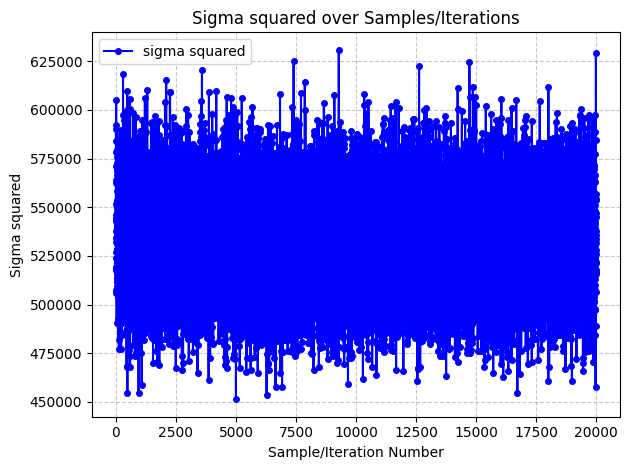

In [8]:
plot_sigma_squared(trainer)

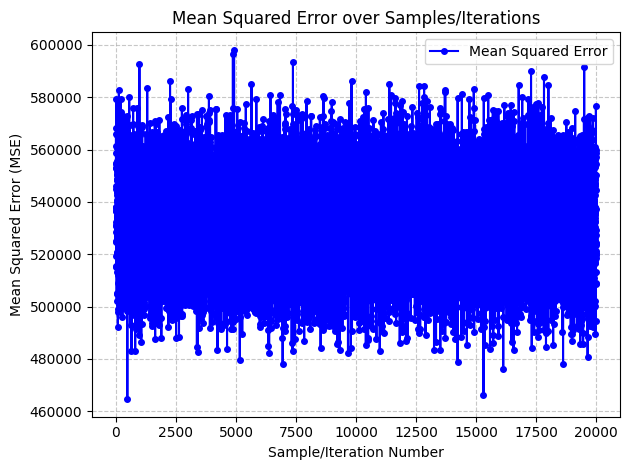

In [9]:
plot_mse(trainer)

In [10]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 205


In [11]:
print(model.input_layer.beta.requires_grad)

True


Threshold δ=1.000, selecting r=25 voxels at FDR=0.05


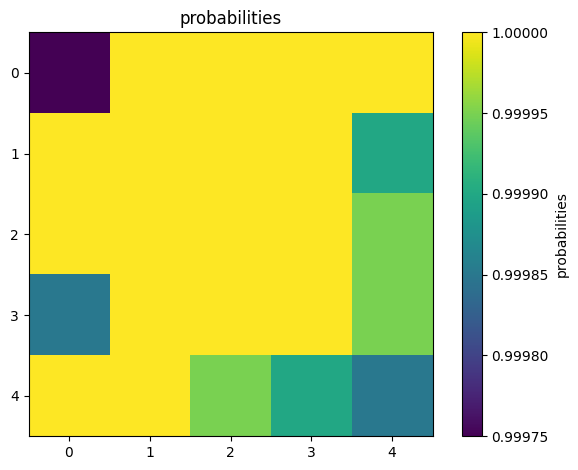

predict (sample_avg)::variance_prediction=[[0.08109237]]
Y(predicted)=tensor([[2.2506]]) Y(expected)=9.600000097464498


In [12]:
print(f"Y(predicted)={trainer.predict(inputs,-100,-1, gamma=0.05)} Y(expected)={expected_y}")